In [76]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn import Module, Sequential, Conv2d, ReLU, MaxPool2d, Linear, BatchNorm2d, Dropout2d
from torch.nn.init import kaiming_uniform_, xavier_uniform_
import torchvision.transforms as transforms
from PIL import Image
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [ ]:
class GRSDataset(Dataset):
    def __init__(self, dataframe, frame_dir, transform=None, sequence_length=32):
        self.data = dataframe.copy()
        self.frame_dir = frame_dir
        self.transform = transform
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        video_id = row["VIDEO"]
        label = int(row["GRS"])
        path = self.frame_dir / video_id

        frames = sorted(path.glob("*.jpg"))
        selected = frames[:self.sequence_length]
        if len(selected) == 0:
            raise IndexError(f"No frames found for video {video_id}")
        while len(selected) < self.sequence_length:
            selected.append(selected[-1])

        images = [self.transform(Image.open(f).convert("RGB")) for f in selected]
        return torch.stack(images), label


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

LABEL_PATH = Path("../data/labels/labels_task1.csv")
FRAME_DIR = Path("../data/frames")

df = pd.read_csv(LABEL_PATH)
available_videos = {p.name for p in FRAME_DIR.iterdir() if p.is_dir() and any(p.glob("*.jpg"))}
df = df[df["VIDEO"].isin(available_videos)].reset_index(drop=True)

dataset = GRSDataset(df, FRAME_DIR, transform)
loader = DataLoader(dataset, batch_size=4, shuffle=True)


In [79]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = ReLU()(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = ReLU()(out)
        return out


class ResNet(nn.Module):
    def __init__(self, num_classes=4):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, 1, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.block1 = self._create_block(64, 64, 1)
        self.block2 = self._create_block(64, 128, 2)
        self.block3 = self._create_block(128, 256, 2)
        self.block4 = self._create_block(256, 512, 2)
        self.linear = nn.Linear(512, num_classes)

    def _create_block(self, in_channels, out_channels, stride):
        return nn.Sequential(
            ResidualBlock(in_channels, out_channels, stride),
            ResidualBlock(out_channels, out_channels, 1)
        )

    def forward(self, x):
        B, T, C, H, W = x.shape
        x = x.view(B * T, C, H, W)

        out = ReLU()(self.bn1(self.conv1(x)))
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)

        out = nn.AvgPool2d(4)(out)
        out = out.view(B, T, -1).mean(dim=1)  # média temporal dos frames

        out = self.linear(out)
        return out

In [80]:
class CNNModel_1(nn.Module):
    def __init__(self, num_classes=4):
        super(CNNModel_1, self).__init__()
        self.layer1 = Sequential(
            Conv2d(3, 32, 3),
            ReLU(),
            MaxPool2d(2, 2)
        )
        self.layer2 = Sequential(
            Conv2d(32, 32, 3),
            ReLU(),
            MaxPool2d(2, 2)
        )
        self.fc1 = Linear(32*6*6, 100)  # para 32x32 input após convoluções e pools
        kaiming_uniform_(self.fc1.weight, nonlinearity='relu')
        self.act1 = ReLU()
        self.fc2 = Linear(100, 4)
        xavier_uniform_(self.fc2.weight)
        self.act2 = nn.Softmax(dim=1)

    def forward(self, x):
        B, T, C, H, W = x.shape
        x = x.view(B * T, C, H, W)
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = out.view(B, T, -1).mean(dim=1)
        out = self.fc1(out)
        out = self.act1(out)
        out = self.fc2(out)
        out = self.act2(out)
        return out


In [81]:
class CNNModel_2(nn.Module):
    def __init__(self, num_classes=4):
        super(CNNModel_2, self).__init__()
        self.layer1 = Sequential(
            Conv2d(3, 16, 3),
            ReLU(),
            MaxPool2d(2)
        )
        self.layer2 = Sequential(
            Conv2d(16, 32, 3),
            ReLU(),
            MaxPool2d(2)
        )
        self.fc1 = Linear(32*6*6, 4)

    def forward(self, x):
        B, T, C, H, W = x.shape
        x = x.view(B * T, C, H, W)
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = out.view(B, T, -1).mean(dim=1)
        out = self.fc1(out)
        return out


In [82]:
class CNNModel_3(nn.Module):
    def __init__(self, num_classes=4):
        super(CNNModel_3, self).__init__()
        self.layer1 = nn.Sequential(
            Conv2d(3, 32, 3, padding=1),
            BatchNorm2d(32),
            ReLU(),
            MaxPool2d(2, 2)
        )
        self.layer2 = nn.Sequential(
            Conv2d(32, 64, 3),
            BatchNorm2d(64),
            ReLU(),
            MaxPool2d(2)
        )
        self.fc1 = Linear(64*7*7, 600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = Linear(600, 120)
        self.fc3 = Linear(120, 4)

    def forward(self, x):
        B, T, C, H, W = x.shape
        x = x.view(B * T, C, H, W)
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = out.view(B, T, -1).mean(dim=1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out


In [83]:
class CNNModel_4(nn.Module):
    def __init__(self, num_classes=4):
        super(CNNModel_4, self).__init__()
        self.layer1 = Sequential(
            Conv2d(3, 32, 5),
            BatchNorm2d(32),
            ReLU(),
            MaxPool2d(2),
            Dropout2d(0.2)
        )
        self.fc1 = Linear(32*14*14, 128)
        self.fc2 = Linear(128, 4)

    def forward(self, x):
        B, T, C, H, W = x.shape
        x = x.view(B * T, C, H, W)
        out = self.layer1(x)
        out = out.view(out.size(0), -1)
        out = out.view(B, T, -1).mean(dim=1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out


In [ ]:
class CNNLSTMClassifier(nn.Module):
    def __init__(self, hidden_dim=128, num_classes=4):
        super(CNNLSTMClassifier, self).__init__()

        # Carregar ResNet18 pré-treinada e remover a fully connected
        base_cnn = models.resnet18(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(base_cnn.children())[:-1])  # até ao penúltimo bloco
        self.feature_dim = base_cnn.fc.in_features  # normalmente 512

        # LSTM para modelar a sequência de features
        self.lstm = nn.LSTM(input_size=self.feature_dim,
                            hidden_size=hidden_dim,
                            num_layers=1,
                            batch_first=True)

        # Camada final para classificação
        self.classifier = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        batch_size, seq_len, c, h, w = x.size()
        x = x.view(batch_size * seq_len, c, h, w)

        # Congelar CNN inicialmente (opcional)
        with torch.no_grad():
            features = self.feature_extractor(x).view(batch_size, seq_len, -1)

        lstm_out, _ = self.lstm(features)
        last_hidden = lstm_out[:, -1, :]
        out = self.classifier(last_hidden)
        return out


In [ ]:
class CNNLSTM_Segmentation(nn.Module):
    def __init__(self, num_classes=5):  # Adjust num_classes for phases
        super().__init__()
        base = models.resnet18(pretrained=True)
        self.cnn = nn.Sequential(*list(base.children())[:-2])  # Up to conv layers
        self.lstm = nn.LSTM(512, 256, num_layers=2, batch_first=True)
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        B, T, C, H, W = x.shape
        x = x.view(B * T, C, H, W)
        feats = self.cnn(x).view(B, T, -1)  # Spatial features
        out, _ = self.lstm(feats)  # Temporal modeling
        return self.fc(out)  # Output per frame

In [85]:
from torchvision import models

class EfficientNetLSTM(nn.Module):
    def __init__(self, hidden_dim=128, num_classes=4):
        super(EfficientNetLSTM, self).__init__()

        base = models.efficientnet_b0(pretrained=True)
        self.feature_extractor = base.features
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.feature_dim = 1280  # saída de efficientnet_b0

        self.lstm = nn.LSTM(input_size=self.feature_dim,
                            hidden_size=hidden_dim,
                            num_layers=1,
                            batch_first=True)
        self.classifier = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        batch_size, seq_len, c, h, w = x.size()
        x = x.view(batch_size * seq_len, c, h, w)
        with torch.no_grad():
            features = self.pool(self.feature_extractor(x)).view(batch_size, seq_len, -1)

        out, _ = self.lstm(features)
        last = out[:, -1, :]
        return self.classifier(last)


In [86]:
from timm import create_model

class ViTTemporalAvg(nn.Module):
    def __init__(self, model_name='vit_base_patch16_224', num_classes=4):
        super(ViTTemporalAvg, self).__init__()
        self.vit = create_model(model_name, pretrained=True)
        self.vit.head = nn.Identity()  # remover camada final
        self.feature_dim = self.vit.num_features

        self.classifier = nn.Linear(self.feature_dim, num_classes)

    def forward(self, x):
        B, T, C, H, W = x.shape
        x = x.view(B * T, C, H, W)
        with torch.no_grad():
            feats = self.vit(x).view(B, T, -1)

        avg_feats = feats.mean(dim=1)
        return self.classifier(avg_feats)

In [104]:
from pytorchvideo.models.hub import timesformer_base

class TimeSformerWrapper(nn.Module):
    def __init__(self, num_classes=4):
        super(TimeSformerWrapper, self).__init__()
        self.model = timesformer_base(pretrained=True)
        self.model.blocks[-1].drop_path_rate = 0.1
        self.model.head = nn.Linear(self.model.head.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

ImportError: cannot import name 'timesformer_base' from 'pytorchvideo.models.hub' (c:\Users\ruben\Desktop\Minho\MEI\SI\AP\.venv\Lib\site-packages\pytorchvideo\models\hub\__init__.py)

In [89]:
def train_model(model, dataloader, epochs=5):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss()
    history = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        for inputs, labels in tqdm(dataloader):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        acc = correct / total
        print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}, Accuracy: {acc:.4f}")
        history.append((total_loss, acc))

    return history


In [90]:
model = EfficientNetLSTM().to(device)
# Ou:
# model = ViTTemporalAvg().to(device)
# model = TimeSformerWrapper().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

n_epochs = 10
for epoch in range(n_epochs):
    train_loss, train_acc, train_f1 = train_one_epoch(model, loader, optimizer, criterion)
    val_loss, val_acc, val_f1 = evaluate(model, loader, criterion)
    print(f"Epoch {epoch+1}/{n_epochs} | Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} F1: {train_f1:.4f} | Val Loss: {val_loss:.4f} Acc: {val_acc:.4f} F1: {val_f1:.4f}")


c:\Users\ruben\Desktop\Minho\MEI\SI\AP\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ruben\Desktop\Minho\MEI\SI\AP\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


NameError: name 'train_one_epoch' is not defined

In [91]:
model1 = CNNModel_1()
hist1 = train_model(model1, loader, 100)

model2 = CNNModel_2()
hist2 = train_model(model2, loader, 100)

model3 = CNNModel_3()
hist3 = train_model(model3, loader, 100)

model4 = CNNModel_4()
hist4 = train_model(model4, loader, 100)


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Epoch 1, Loss: 10.9581, Accuracy: 0.2667


100%|██████████| 8/8 [00:00<00:00,  8.32it/s]


Epoch 2, Loss: 10.8999, Accuracy: 0.3333


100%|██████████| 8/8 [00:00<00:00,  8.31it/s]


Epoch 3, Loss: 10.7124, Accuracy: 0.4333


100%|██████████| 8/8 [00:00<00:00,  8.04it/s]


Epoch 4, Loss: 10.6693, Accuracy: 0.4333


100%|██████████| 8/8 [00:00<00:00,  8.12it/s]


Epoch 5, Loss: 10.4361, Accuracy: 0.4333


100%|██████████| 8/8 [00:00<00:00,  8.07it/s]


Epoch 6, Loss: 10.3999, Accuracy: 0.4333


100%|██████████| 8/8 [00:01<00:00,  7.58it/s]


Epoch 7, Loss: 10.4609, Accuracy: 0.4333


100%|██████████| 8/8 [00:01<00:00,  7.97it/s]


Epoch 8, Loss: 10.2364, Accuracy: 0.4333


100%|██████████| 8/8 [00:01<00:00,  7.86it/s]


Epoch 9, Loss: 10.2995, Accuracy: 0.4333


100%|██████████| 8/8 [00:00<00:00,  8.24it/s]


Epoch 10, Loss: 10.2134, Accuracy: 0.4333


100%|██████████| 8/8 [00:00<00:00,  8.44it/s]


Epoch 11, Loss: 10.0927, Accuracy: 0.4667


100%|██████████| 8/8 [00:00<00:00,  8.15it/s]


Epoch 12, Loss: 10.1712, Accuracy: 0.5000


100%|██████████| 8/8 [00:00<00:00,  8.37it/s]


Epoch 13, Loss: 9.7857, Accuracy: 0.5000


100%|██████████| 8/8 [00:00<00:00,  8.42it/s]


Epoch 14, Loss: 9.7777, Accuracy: 0.5000


100%|██████████| 8/8 [00:00<00:00,  8.57it/s]


Epoch 15, Loss: 9.7566, Accuracy: 0.5000


100%|██████████| 8/8 [00:00<00:00,  8.24it/s]


Epoch 16, Loss: 9.6106, Accuracy: 0.5667


100%|██████████| 8/8 [00:01<00:00,  6.54it/s]


Epoch 17, Loss: 9.5497, Accuracy: 0.5333


100%|██████████| 8/8 [00:01<00:00,  7.91it/s]


Epoch 18, Loss: 9.6647, Accuracy: 0.5333


100%|██████████| 8/8 [00:01<00:00,  7.43it/s]


Epoch 19, Loss: 9.4514, Accuracy: 0.6333


100%|██████████| 8/8 [00:00<00:00,  8.64it/s]


Epoch 20, Loss: 9.3506, Accuracy: 0.7333


100%|██████████| 8/8 [00:00<00:00,  8.59it/s]


Epoch 21, Loss: 9.1742, Accuracy: 0.7333


100%|██████████| 8/8 [00:00<00:00,  8.34it/s]


Epoch 22, Loss: 9.1182, Accuracy: 0.7000


100%|██████████| 8/8 [00:00<00:00,  8.48it/s]


Epoch 23, Loss: 9.2637, Accuracy: 0.7000


100%|██████████| 8/8 [00:01<00:00,  7.89it/s]


Epoch 24, Loss: 8.9543, Accuracy: 0.7333


100%|██████████| 8/8 [00:00<00:00,  8.21it/s]


Epoch 25, Loss: 9.0040, Accuracy: 0.7667


100%|██████████| 8/8 [00:00<00:00,  8.26it/s]


Epoch 26, Loss: 8.6557, Accuracy: 0.7667


100%|██████████| 8/8 [00:01<00:00,  7.73it/s]


Epoch 27, Loss: 8.8969, Accuracy: 0.7000


100%|██████████| 8/8 [00:00<00:00,  8.04it/s]


Epoch 28, Loss: 8.8648, Accuracy: 0.7000


100%|██████████| 8/8 [00:00<00:00,  8.47it/s]


Epoch 29, Loss: 8.6353, Accuracy: 0.8000


100%|██████████| 8/8 [00:00<00:00,  8.30it/s]


Epoch 30, Loss: 8.4016, Accuracy: 0.8000


100%|██████████| 8/8 [00:00<00:00,  8.56it/s]


Epoch 31, Loss: 8.3735, Accuracy: 0.7333


100%|██████████| 8/8 [00:01<00:00,  7.88it/s]


Epoch 32, Loss: 8.2713, Accuracy: 0.7333


100%|██████████| 8/8 [00:00<00:00,  8.38it/s]


Epoch 33, Loss: 8.5310, Accuracy: 0.8000


100%|██████████| 8/8 [00:00<00:00,  8.29it/s]


Epoch 34, Loss: 8.2416, Accuracy: 0.7667


100%|██████████| 8/8 [00:00<00:00,  8.76it/s]


Epoch 35, Loss: 8.3235, Accuracy: 0.7667


100%|██████████| 8/8 [00:00<00:00,  8.76it/s]


Epoch 36, Loss: 8.3419, Accuracy: 0.8000


100%|██████████| 8/8 [00:01<00:00,  7.86it/s]


Epoch 37, Loss: 8.0178, Accuracy: 0.8000


100%|██████████| 8/8 [00:00<00:00,  8.54it/s]


Epoch 38, Loss: 7.9249, Accuracy: 0.8000


100%|██████████| 8/8 [00:00<00:00,  8.70it/s]


Epoch 39, Loss: 8.0155, Accuracy: 0.8000


100%|██████████| 8/8 [00:00<00:00,  8.54it/s]


Epoch 40, Loss: 8.2363, Accuracy: 0.8000


100%|██████████| 8/8 [00:00<00:00,  8.77it/s]


Epoch 41, Loss: 7.7780, Accuracy: 0.8000


100%|██████████| 8/8 [00:00<00:00,  8.00it/s]


Epoch 42, Loss: 7.7503, Accuracy: 0.8000


100%|██████████| 8/8 [00:01<00:00,  7.08it/s]


Epoch 43, Loss: 7.9616, Accuracy: 0.8000


100%|██████████| 8/8 [00:01<00:00,  7.63it/s]


Epoch 44, Loss: 7.8808, Accuracy: 0.8333


100%|██████████| 8/8 [00:00<00:00,  8.13it/s]


Epoch 45, Loss: 7.6529, Accuracy: 0.8333


100%|██████████| 8/8 [00:01<00:00,  7.65it/s]


Epoch 46, Loss: 7.6419, Accuracy: 0.8667


100%|██████████| 8/8 [00:00<00:00,  8.18it/s]


Epoch 47, Loss: 7.7138, Accuracy: 0.8667


100%|██████████| 8/8 [00:02<00:00,  3.95it/s]


Epoch 48, Loss: 7.7386, Accuracy: 0.8667


100%|██████████| 8/8 [00:02<00:00,  3.55it/s]


Epoch 49, Loss: 7.5186, Accuracy: 0.8667


100%|██████████| 8/8 [00:02<00:00,  3.06it/s]


Epoch 50, Loss: 7.6482, Accuracy: 0.8667


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Epoch 51, Loss: 7.4161, Accuracy: 0.8667


100%|██████████| 8/8 [00:03<00:00,  2.55it/s]


Epoch 52, Loss: 7.4763, Accuracy: 0.8667


100%|██████████| 8/8 [00:01<00:00,  4.00it/s]


Epoch 53, Loss: 7.3965, Accuracy: 0.8667


100%|██████████| 8/8 [00:00<00:00,  8.15it/s]


Epoch 54, Loss: 7.3186, Accuracy: 0.8667


100%|██████████| 8/8 [00:01<00:00,  7.98it/s]


Epoch 55, Loss: 7.2967, Accuracy: 0.8667


100%|██████████| 8/8 [00:00<00:00,  8.25it/s]


Epoch 56, Loss: 7.2711, Accuracy: 0.8667


100%|██████████| 8/8 [00:00<00:00,  8.47it/s]


Epoch 57, Loss: 7.4711, Accuracy: 0.8667


100%|██████████| 8/8 [00:00<00:00,  8.32it/s]


Epoch 58, Loss: 7.2222, Accuracy: 0.8667


100%|██████████| 8/8 [00:01<00:00,  7.78it/s]


Epoch 59, Loss: 7.2053, Accuracy: 0.8667


100%|██████████| 8/8 [00:00<00:00,  8.20it/s]


Epoch 60, Loss: 7.2142, Accuracy: 0.8667


100%|██████████| 8/8 [00:01<00:00,  7.79it/s]


Epoch 61, Loss: 7.1711, Accuracy: 0.8667


100%|██████████| 8/8 [00:00<00:00,  8.13it/s]


Epoch 62, Loss: 7.1515, Accuracy: 0.8667


100%|██████████| 8/8 [00:00<00:00,  8.42it/s]


Epoch 63, Loss: 7.1212, Accuracy: 0.8667


100%|██████████| 8/8 [00:00<00:00,  8.41it/s]


Epoch 64, Loss: 7.1083, Accuracy: 0.8667


100%|██████████| 8/8 [00:00<00:00,  8.54it/s]


Epoch 65, Loss: 7.0936, Accuracy: 0.8667


100%|██████████| 8/8 [00:00<00:00,  8.52it/s]


Epoch 66, Loss: 7.0813, Accuracy: 0.8667


100%|██████████| 8/8 [00:00<00:00,  8.53it/s]


Epoch 67, Loss: 7.0690, Accuracy: 0.8667


100%|██████████| 8/8 [00:01<00:00,  7.09it/s]


Epoch 68, Loss: 7.0826, Accuracy: 0.8667


100%|██████████| 8/8 [00:00<00:00,  8.50it/s]


Epoch 69, Loss: 7.0499, Accuracy: 0.8667


100%|██████████| 8/8 [00:00<00:00,  8.19it/s]


Epoch 70, Loss: 7.2609, Accuracy: 0.8667


100%|██████████| 8/8 [00:00<00:00,  8.14it/s]


Epoch 71, Loss: 7.0460, Accuracy: 0.8667


100%|██████████| 8/8 [00:00<00:00,  8.24it/s]


Epoch 72, Loss: 7.2115, Accuracy: 0.8667


100%|██████████| 8/8 [00:00<00:00,  8.90it/s]


Epoch 73, Loss: 7.0207, Accuracy: 0.8667


100%|██████████| 8/8 [00:01<00:00,  7.91it/s]


Epoch 74, Loss: 6.9691, Accuracy: 0.8667


100%|██████████| 8/8 [00:00<00:00,  8.46it/s]


Epoch 75, Loss: 6.9729, Accuracy: 0.8667


100%|██████████| 8/8 [00:00<00:00,  8.92it/s]


Epoch 76, Loss: 6.9685, Accuracy: 0.8667


100%|██████████| 8/8 [00:00<00:00,  8.26it/s]


Epoch 77, Loss: 6.9375, Accuracy: 0.9000


100%|██████████| 8/8 [00:01<00:00,  7.54it/s]


Epoch 78, Loss: 7.1375, Accuracy: 0.9000


100%|██████████| 8/8 [00:01<00:00,  7.80it/s]


Epoch 79, Loss: 7.1632, Accuracy: 0.9000


100%|██████████| 8/8 [00:00<00:00,  8.30it/s]


Epoch 80, Loss: 6.9204, Accuracy: 0.9000


100%|██████████| 8/8 [00:01<00:00,  7.99it/s]


Epoch 81, Loss: 7.1220, Accuracy: 0.9000


100%|██████████| 8/8 [00:00<00:00,  8.79it/s]


Epoch 82, Loss: 7.1016, Accuracy: 0.9000


100%|██████████| 8/8 [00:01<00:00,  7.76it/s]


Epoch 83, Loss: 6.8489, Accuracy: 0.9000


100%|██████████| 8/8 [00:01<00:00,  7.77it/s]


Epoch 84, Loss: 6.8435, Accuracy: 0.9000


100%|██████████| 8/8 [00:01<00:00,  7.99it/s]


Epoch 85, Loss: 6.8422, Accuracy: 0.9000


100%|██████████| 8/8 [00:01<00:00,  8.00it/s]


Epoch 86, Loss: 6.8274, Accuracy: 0.9000


100%|██████████| 8/8 [00:01<00:00,  7.73it/s]


Epoch 87, Loss: 6.8264, Accuracy: 0.9000


100%|██████████| 8/8 [00:01<00:00,  7.33it/s]


Epoch 88, Loss: 6.8115, Accuracy: 0.9000


100%|██████████| 8/8 [00:01<00:00,  7.53it/s]


Epoch 89, Loss: 7.0401, Accuracy: 0.9000


100%|██████████| 8/8 [00:01<00:00,  7.13it/s]


Epoch 90, Loss: 6.8286, Accuracy: 0.9000


100%|██████████| 8/8 [00:00<00:00,  8.26it/s]


Epoch 91, Loss: 6.8028, Accuracy: 0.9000


100%|██████████| 8/8 [00:00<00:00,  8.10it/s]


Epoch 92, Loss: 7.0212, Accuracy: 0.9000


100%|██████████| 8/8 [00:01<00:00,  7.71it/s]


Epoch 93, Loss: 6.7756, Accuracy: 0.9000


100%|██████████| 8/8 [00:01<00:00,  7.88it/s]


Epoch 94, Loss: 6.7803, Accuracy: 0.9000


100%|██████████| 8/8 [00:01<00:00,  7.97it/s]


Epoch 95, Loss: 6.7684, Accuracy: 0.9000


100%|██████████| 8/8 [00:01<00:00,  7.92it/s]


Epoch 96, Loss: 6.7673, Accuracy: 0.9000


100%|██████████| 8/8 [00:00<00:00,  8.21it/s]


Epoch 97, Loss: 6.7588, Accuracy: 0.9000


100%|██████████| 8/8 [00:01<00:00,  7.73it/s]


Epoch 98, Loss: 6.9798, Accuracy: 0.9000


100%|██████████| 8/8 [00:01<00:00,  7.96it/s]


Epoch 99, Loss: 6.7469, Accuracy: 0.9000


100%|██████████| 8/8 [00:00<00:00,  8.41it/s]


Epoch 100, Loss: 6.7570, Accuracy: 0.9000


100%|██████████| 8/8 [00:00<00:00,  8.35it/s]


Epoch 1, Loss: 11.0188, Accuracy: 0.3333


100%|██████████| 8/8 [00:00<00:00,  8.71it/s]


Epoch 2, Loss: 10.8007, Accuracy: 0.3667


100%|██████████| 8/8 [00:00<00:00,  8.64it/s]


Epoch 3, Loss: 10.6500, Accuracy: 0.4333


100%|██████████| 8/8 [00:00<00:00,  8.54it/s]


Epoch 4, Loss: 10.5543, Accuracy: 0.4333


100%|██████████| 8/8 [00:00<00:00,  8.62it/s]


Epoch 5, Loss: 10.3449, Accuracy: 0.4333


100%|██████████| 8/8 [00:01<00:00,  7.98it/s]


Epoch 6, Loss: 10.3697, Accuracy: 0.4333


100%|██████████| 8/8 [00:01<00:00,  7.41it/s]


Epoch 7, Loss: 10.4207, Accuracy: 0.4333


100%|██████████| 8/8 [00:00<00:00,  8.31it/s]


Epoch 8, Loss: 10.1183, Accuracy: 0.4333


100%|██████████| 8/8 [00:00<00:00,  8.30it/s]


Epoch 9, Loss: 10.2974, Accuracy: 0.4333


100%|██████████| 8/8 [00:00<00:00,  8.48it/s]


Epoch 10, Loss: 10.1059, Accuracy: 0.4333


100%|██████████| 8/8 [00:01<00:00,  7.96it/s]


Epoch 11, Loss: 9.9512, Accuracy: 0.4333


100%|██████████| 8/8 [00:00<00:00,  8.18it/s]


Epoch 12, Loss: 9.8931, Accuracy: 0.4333


100%|██████████| 8/8 [00:00<00:00,  8.51it/s]


Epoch 13, Loss: 9.8117, Accuracy: 0.4333


100%|██████████| 8/8 [00:00<00:00,  8.68it/s]


Epoch 14, Loss: 9.7692, Accuracy: 0.4333


100%|██████████| 8/8 [00:00<00:00,  9.01it/s]


Epoch 15, Loss: 9.8845, Accuracy: 0.4333


100%|██████████| 8/8 [00:00<00:00,  8.93it/s]


Epoch 16, Loss: 9.7784, Accuracy: 0.4333


100%|██████████| 8/8 [00:00<00:00,  8.50it/s]


Epoch 17, Loss: 9.4468, Accuracy: 0.4333


100%|██████████| 8/8 [00:00<00:00,  8.74it/s]


Epoch 18, Loss: 9.5085, Accuracy: 0.4333


100%|██████████| 8/8 [00:01<00:00,  6.62it/s]


Epoch 19, Loss: 9.6263, Accuracy: 0.4333


100%|██████████| 8/8 [00:00<00:00,  9.04it/s]


Epoch 20, Loss: 9.5314, Accuracy: 0.4333


100%|██████████| 8/8 [00:00<00:00,  8.97it/s]


Epoch 21, Loss: 9.6652, Accuracy: 0.4333


100%|██████████| 8/8 [00:00<00:00,  8.74it/s]


Epoch 22, Loss: 9.5111, Accuracy: 0.4333


100%|██████████| 8/8 [00:00<00:00,  8.62it/s]


Epoch 23, Loss: 9.2746, Accuracy: 0.4667


100%|██████████| 8/8 [00:00<00:00,  8.90it/s]


Epoch 24, Loss: 8.9877, Accuracy: 0.4667


100%|██████████| 8/8 [00:00<00:00,  9.03it/s]


Epoch 25, Loss: 9.6449, Accuracy: 0.5000


100%|██████████| 8/8 [00:00<00:00,  8.39it/s]


Epoch 26, Loss: 9.1376, Accuracy: 0.5333


100%|██████████| 8/8 [00:01<00:00,  7.78it/s]


Epoch 27, Loss: 8.7723, Accuracy: 0.5333


100%|██████████| 8/8 [00:00<00:00,  8.43it/s]


Epoch 28, Loss: 8.7148, Accuracy: 0.5333


100%|██████████| 8/8 [00:00<00:00,  8.82it/s]


Epoch 29, Loss: 8.6057, Accuracy: 0.6000


100%|██████████| 8/8 [00:00<00:00,  9.14it/s]


Epoch 30, Loss: 8.7433, Accuracy: 0.6000


100%|██████████| 8/8 [00:00<00:00,  8.81it/s]


Epoch 31, Loss: 8.2853, Accuracy: 0.6000


100%|██████████| 8/8 [00:00<00:00,  8.62it/s]


Epoch 32, Loss: 8.3148, Accuracy: 0.6000


100%|██████████| 8/8 [00:00<00:00,  8.51it/s]


Epoch 33, Loss: 8.0630, Accuracy: 0.6000


100%|██████████| 8/8 [00:00<00:00,  8.42it/s]


Epoch 34, Loss: 8.0874, Accuracy: 0.6000


100%|██████████| 8/8 [00:00<00:00,  8.21it/s]


Epoch 35, Loss: 8.0240, Accuracy: 0.6000


100%|██████████| 8/8 [00:00<00:00,  9.03it/s]


Epoch 36, Loss: 7.8987, Accuracy: 0.6000


100%|██████████| 8/8 [00:00<00:00,  8.76it/s]


Epoch 37, Loss: 7.6705, Accuracy: 0.6000


100%|██████████| 8/8 [00:00<00:00,  8.81it/s]


Epoch 38, Loss: 7.6798, Accuracy: 0.6000


100%|██████████| 8/8 [00:00<00:00,  8.81it/s]


Epoch 39, Loss: 7.3879, Accuracy: 0.6000


100%|██████████| 8/8 [00:00<00:00,  8.92it/s]


Epoch 40, Loss: 7.3112, Accuracy: 0.6333


100%|██████████| 8/8 [00:00<00:00,  8.73it/s]


Epoch 41, Loss: 7.4012, Accuracy: 0.6333


100%|██████████| 8/8 [00:00<00:00,  8.85it/s]


Epoch 42, Loss: 7.1958, Accuracy: 0.6333


100%|██████████| 8/8 [00:00<00:00,  8.69it/s]


Epoch 43, Loss: 7.4899, Accuracy: 0.6667


100%|██████████| 8/8 [00:00<00:00,  8.87it/s]


Epoch 44, Loss: 7.0485, Accuracy: 0.6667


100%|██████████| 8/8 [00:00<00:00,  8.10it/s]


Epoch 45, Loss: 6.7850, Accuracy: 0.6667


100%|██████████| 8/8 [00:00<00:00,  8.03it/s]


Epoch 46, Loss: 7.2127, Accuracy: 0.6667


100%|██████████| 8/8 [00:01<00:00,  7.97it/s]


Epoch 47, Loss: 6.6423, Accuracy: 0.6667


100%|██████████| 8/8 [00:01<00:00,  7.82it/s]


Epoch 48, Loss: 6.3259, Accuracy: 0.6667


100%|██████████| 8/8 [00:01<00:00,  7.93it/s]


Epoch 49, Loss: 6.2171, Accuracy: 0.6667


100%|██████████| 8/8 [00:01<00:00,  7.87it/s]


Epoch 50, Loss: 6.2833, Accuracy: 0.7000


100%|██████████| 8/8 [00:00<00:00,  8.18it/s]


Epoch 51, Loss: 6.0064, Accuracy: 0.6667


100%|██████████| 8/8 [00:01<00:00,  7.17it/s]


Epoch 52, Loss: 6.0213, Accuracy: 0.7000


100%|██████████| 8/8 [00:01<00:00,  7.75it/s]


Epoch 53, Loss: 5.9891, Accuracy: 0.7667


100%|██████████| 8/8 [00:01<00:00,  6.10it/s]


Epoch 54, Loss: 5.9664, Accuracy: 0.7333


100%|██████████| 8/8 [00:01<00:00,  7.85it/s]


Epoch 55, Loss: 5.6246, Accuracy: 0.7333


100%|██████████| 8/8 [00:00<00:00,  8.49it/s]


Epoch 56, Loss: 5.5108, Accuracy: 0.7333


100%|██████████| 8/8 [00:01<00:00,  7.12it/s]


Epoch 57, Loss: 5.4444, Accuracy: 0.8000


100%|██████████| 8/8 [00:01<00:00,  7.75it/s]


Epoch 58, Loss: 6.0626, Accuracy: 0.7667


100%|██████████| 8/8 [00:00<00:00,  8.64it/s]


Epoch 59, Loss: 5.2547, Accuracy: 0.8000


100%|██████████| 8/8 [00:00<00:00,  8.89it/s]


Epoch 60, Loss: 5.4162, Accuracy: 0.8333


100%|██████████| 8/8 [00:01<00:00,  7.82it/s]


Epoch 61, Loss: 5.1074, Accuracy: 0.8667


100%|██████████| 8/8 [00:01<00:00,  7.75it/s]


Epoch 62, Loss: 5.2162, Accuracy: 0.8667


100%|██████████| 8/8 [00:01<00:00,  7.52it/s]


Epoch 63, Loss: 5.0742, Accuracy: 0.8667


100%|██████████| 8/8 [00:00<00:00,  8.29it/s]


Epoch 64, Loss: 5.1828, Accuracy: 0.8333


100%|██████████| 8/8 [00:01<00:00,  7.75it/s]


Epoch 65, Loss: 4.9008, Accuracy: 0.8667


100%|██████████| 8/8 [00:00<00:00,  8.11it/s]


Epoch 66, Loss: 4.8535, Accuracy: 0.8667


100%|██████████| 8/8 [00:00<00:00,  8.62it/s]


Epoch 67, Loss: 4.6929, Accuracy: 0.8667


100%|██████████| 8/8 [00:00<00:00,  8.18it/s]


Epoch 68, Loss: 4.5899, Accuracy: 0.8667


100%|██████████| 8/8 [00:00<00:00,  8.59it/s]


Epoch 69, Loss: 4.8796, Accuracy: 0.8333


100%|██████████| 8/8 [00:01<00:00,  5.85it/s]


Epoch 70, Loss: 4.3576, Accuracy: 0.8333


100%|██████████| 8/8 [00:00<00:00,  8.92it/s]


Epoch 71, Loss: 4.4956, Accuracy: 0.8667


100%|██████████| 8/8 [00:00<00:00,  8.82it/s]


Epoch 72, Loss: 4.3784, Accuracy: 0.8667


100%|██████████| 8/8 [00:00<00:00,  8.61it/s]


Epoch 73, Loss: 4.2699, Accuracy: 0.8667


100%|██████████| 8/8 [00:00<00:00,  9.03it/s]


Epoch 74, Loss: 4.2657, Accuracy: 0.8667


100%|██████████| 8/8 [00:00<00:00,  8.43it/s]


Epoch 75, Loss: 4.3186, Accuracy: 0.8667


100%|██████████| 8/8 [00:00<00:00,  8.22it/s]


Epoch 76, Loss: 4.1585, Accuracy: 0.8667


100%|██████████| 8/8 [00:00<00:00,  8.74it/s]


Epoch 77, Loss: 3.9753, Accuracy: 0.8667


100%|██████████| 8/8 [00:00<00:00,  8.89it/s]


Epoch 78, Loss: 3.9116, Accuracy: 0.8667


100%|██████████| 8/8 [00:00<00:00,  8.46it/s]


Epoch 79, Loss: 4.2372, Accuracy: 0.8667


100%|██████████| 8/8 [00:00<00:00,  8.57it/s]


Epoch 80, Loss: 4.0234, Accuracy: 0.8667


100%|██████████| 8/8 [00:00<00:00,  8.22it/s]


Epoch 81, Loss: 3.8512, Accuracy: 0.8333


100%|██████████| 8/8 [00:01<00:00,  7.74it/s]


Epoch 82, Loss: 3.7896, Accuracy: 0.8667


100%|██████████| 8/8 [00:00<00:00,  9.14it/s]


Epoch 83, Loss: 3.4888, Accuracy: 0.8667


100%|██████████| 8/8 [00:00<00:00,  8.34it/s]


Epoch 84, Loss: 3.6441, Accuracy: 0.8667


100%|██████████| 8/8 [00:00<00:00,  8.69it/s]


Epoch 85, Loss: 3.6788, Accuracy: 0.8667


100%|██████████| 8/8 [00:00<00:00,  9.32it/s]


Epoch 86, Loss: 3.3443, Accuracy: 0.9000


100%|██████████| 8/8 [00:00<00:00,  9.08it/s]


Epoch 87, Loss: 3.4619, Accuracy: 0.9000


100%|██████████| 8/8 [00:00<00:00,  9.31it/s]


Epoch 88, Loss: 3.3877, Accuracy: 0.8667


100%|██████████| 8/8 [00:00<00:00,  8.68it/s]


Epoch 89, Loss: 3.3649, Accuracy: 0.8667


100%|██████████| 8/8 [00:00<00:00,  8.72it/s]


Epoch 90, Loss: 3.3269, Accuracy: 0.8667


100%|██████████| 8/8 [00:00<00:00,  9.20it/s]


Epoch 91, Loss: 3.0951, Accuracy: 0.8667


100%|██████████| 8/8 [00:00<00:00,  9.06it/s]


Epoch 92, Loss: 3.1367, Accuracy: 0.8667


100%|██████████| 8/8 [00:00<00:00,  8.30it/s]


Epoch 93, Loss: 3.1018, Accuracy: 0.9000


100%|██████████| 8/8 [00:00<00:00,  9.60it/s]


Epoch 94, Loss: 3.0149, Accuracy: 0.9333


100%|██████████| 8/8 [00:00<00:00,  9.58it/s]


Epoch 95, Loss: 3.2656, Accuracy: 0.9333


100%|██████████| 8/8 [00:00<00:00,  9.37it/s]


Epoch 96, Loss: 2.9230, Accuracy: 0.9333


100%|██████████| 8/8 [00:00<00:00,  8.99it/s]


Epoch 97, Loss: 2.9234, Accuracy: 0.9667


100%|██████████| 8/8 [00:00<00:00,  9.57it/s]


Epoch 98, Loss: 3.1162, Accuracy: 0.8667


100%|██████████| 8/8 [00:00<00:00,  8.67it/s]


Epoch 99, Loss: 2.9634, Accuracy: 0.9000


100%|██████████| 8/8 [00:00<00:00,  8.53it/s]


Epoch 100, Loss: 2.7966, Accuracy: 0.9667


  0%|          | 0/8 [00:00<?, ?it/s]c:\Users\ruben\Desktop\Minho\MEI\SI\AP\.venv\Lib\site-packages\torch\nn\functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
100%|██████████| 8/8 [00:01<00:00,  6.09it/s]


Epoch 1, Loss: 16.1792, Accuracy: 0.2333


100%|██████████| 8/8 [00:01<00:00,  7.04it/s]


Epoch 2, Loss: 11.0295, Accuracy: 0.4667


100%|██████████| 8/8 [00:01<00:00,  7.47it/s]


Epoch 3, Loss: 8.6505, Accuracy: 0.5333


100%|██████████| 8/8 [00:01<00:00,  7.37it/s]


Epoch 4, Loss: 8.6466, Accuracy: 0.4667


100%|██████████| 8/8 [00:01<00:00,  7.01it/s]


Epoch 5, Loss: 6.7585, Accuracy: 0.8000


100%|██████████| 8/8 [00:01<00:00,  7.48it/s]


Epoch 6, Loss: 5.5652, Accuracy: 0.8667


100%|██████████| 8/8 [00:01<00:00,  7.08it/s]


Epoch 7, Loss: 5.4198, Accuracy: 0.7667


100%|██████████| 8/8 [00:01<00:00,  7.13it/s]


Epoch 8, Loss: 4.1184, Accuracy: 0.8667


100%|██████████| 8/8 [00:01<00:00,  7.36it/s]


Epoch 9, Loss: 3.6298, Accuracy: 0.8667


100%|██████████| 8/8 [00:01<00:00,  7.31it/s]


Epoch 10, Loss: 3.1867, Accuracy: 0.9667


100%|██████████| 8/8 [00:01<00:00,  7.43it/s]


Epoch 11, Loss: 2.1590, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  7.32it/s]


Epoch 12, Loss: 1.9933, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  7.00it/s]


Epoch 13, Loss: 1.6616, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  7.25it/s]


Epoch 14, Loss: 1.5508, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  7.31it/s]


Epoch 15, Loss: 1.3339, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  7.04it/s]


Epoch 16, Loss: 0.9485, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  7.43it/s]


Epoch 17, Loss: 0.8370, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  7.25it/s]


Epoch 18, Loss: 0.6609, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  7.21it/s]


Epoch 19, Loss: 0.6472, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


Epoch 20, Loss: 0.4712, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  6.98it/s]


Epoch 21, Loss: 0.5483, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  6.92it/s]


Epoch 22, Loss: 0.4020, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  7.13it/s]


Epoch 23, Loss: 0.2644, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  7.49it/s]


Epoch 24, Loss: 0.3004, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  7.25it/s]


Epoch 25, Loss: 0.2450, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  7.26it/s]


Epoch 26, Loss: 0.2170, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  7.52it/s]


Epoch 27, Loss: 0.2065, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  7.36it/s]


Epoch 28, Loss: 0.1846, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  6.95it/s]


Epoch 29, Loss: 0.1779, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  7.22it/s]


Epoch 30, Loss: 0.1658, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  6.71it/s]


Epoch 31, Loss: 0.1386, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  7.21it/s]


Epoch 32, Loss: 0.1341, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  7.21it/s]


Epoch 33, Loss: 0.1735, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  7.45it/s]


Epoch 34, Loss: 0.1190, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  7.29it/s]


Epoch 35, Loss: 0.1177, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  7.47it/s]


Epoch 36, Loss: 0.0884, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  7.29it/s]


Epoch 37, Loss: 0.0924, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  7.51it/s]


Epoch 38, Loss: 0.0837, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  6.96it/s]


Epoch 39, Loss: 0.0786, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  6.91it/s]


Epoch 40, Loss: 0.0735, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  7.03it/s]


Epoch 41, Loss: 0.0836, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  7.37it/s]


Epoch 42, Loss: 0.0942, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  7.41it/s]


Epoch 43, Loss: 0.0681, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  7.17it/s]


Epoch 44, Loss: 0.0539, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  7.61it/s]


Epoch 45, Loss: 0.0700, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  7.55it/s]


Epoch 46, Loss: 0.0503, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  6.95it/s]


Epoch 47, Loss: 0.0488, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  6.96it/s]


Epoch 48, Loss: 0.0591, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  7.24it/s]


Epoch 49, Loss: 0.0521, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  6.92it/s]


Epoch 50, Loss: 0.0475, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  6.53it/s]


Epoch 51, Loss: 0.0580, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  5.64it/s]


Epoch 52, Loss: 0.0465, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  5.71it/s]


Epoch 53, Loss: 0.0413, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  6.79it/s]


Epoch 54, Loss: 0.0376, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  7.24it/s]


Epoch 55, Loss: 0.0386, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  7.00it/s]


Epoch 56, Loss: 0.0357, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  6.50it/s]


Epoch 57, Loss: 0.0297, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  6.70it/s]


Epoch 58, Loss: 0.0321, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  6.95it/s]


Epoch 59, Loss: 0.0306, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  7.07it/s]


Epoch 60, Loss: 0.0408, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  7.19it/s]


Epoch 61, Loss: 0.0362, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  7.01it/s]


Epoch 62, Loss: 0.0434, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  6.96it/s]


Epoch 63, Loss: 0.0217, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  6.95it/s]


Epoch 64, Loss: 0.0235, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  7.19it/s]


Epoch 65, Loss: 0.0247, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  7.17it/s]


Epoch 66, Loss: 0.0238, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  7.17it/s]


Epoch 67, Loss: 0.0223, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  7.31it/s]


Epoch 68, Loss: 0.0200, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  7.22it/s]


Epoch 69, Loss: 0.0256, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  7.30it/s]


Epoch 70, Loss: 0.0249, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  5.93it/s]


Epoch 71, Loss: 0.0197, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  6.38it/s]


Epoch 72, Loss: 0.0222, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  6.71it/s]


Epoch 73, Loss: 0.0194, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  7.36it/s]


Epoch 74, Loss: 0.0313, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  6.96it/s]


Epoch 75, Loss: 0.0156, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  7.17it/s]


Epoch 76, Loss: 0.0202, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  7.15it/s]


Epoch 77, Loss: 0.0153, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  7.02it/s]


Epoch 78, Loss: 0.0159, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  7.13it/s]


Epoch 79, Loss: 0.0156, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  6.82it/s]


Epoch 80, Loss: 0.0210, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  6.86it/s]


Epoch 81, Loss: 0.0147, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  7.17it/s]


Epoch 82, Loss: 0.0172, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  7.25it/s]


Epoch 83, Loss: 0.0196, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  6.48it/s]


Epoch 84, Loss: 0.0218, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  7.09it/s]


Epoch 85, Loss: 0.0172, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  6.58it/s]


Epoch 86, Loss: 0.0111, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  7.38it/s]


Epoch 87, Loss: 0.0146, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  7.17it/s]


Epoch 88, Loss: 0.0119, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  7.03it/s]


Epoch 89, Loss: 0.0142, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  6.53it/s]


Epoch 90, Loss: 0.0104, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  6.94it/s]


Epoch 91, Loss: 0.0151, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  7.04it/s]


Epoch 92, Loss: 0.0086, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  6.19it/s]


Epoch 93, Loss: 0.0158, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  6.79it/s]


Epoch 94, Loss: 0.0156, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  7.19it/s]


Epoch 95, Loss: 0.0122, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  6.57it/s]


Epoch 96, Loss: 0.0116, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  7.38it/s]


Epoch 97, Loss: 0.0114, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  6.98it/s]


Epoch 98, Loss: 0.0136, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  7.06it/s]


Epoch 99, Loss: 0.0104, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  7.02it/s]


Epoch 100, Loss: 0.0097, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00,  8.21it/s]


Epoch 1, Loss: 15.4872, Accuracy: 0.4000


100%|██████████| 8/8 [00:00<00:00,  8.57it/s]


Epoch 2, Loss: 10.9554, Accuracy: 0.4000


100%|██████████| 8/8 [00:00<00:00,  8.34it/s]


Epoch 3, Loss: 8.6577, Accuracy: 0.5000


100%|██████████| 8/8 [00:00<00:00,  8.51it/s]


Epoch 4, Loss: 5.6197, Accuracy: 0.8000


100%|██████████| 8/8 [00:00<00:00,  8.27it/s]


Epoch 5, Loss: 4.9273, Accuracy: 0.8333


100%|██████████| 8/8 [00:01<00:00,  7.88it/s]


Epoch 6, Loss: 4.1919, Accuracy: 0.9000


100%|██████████| 8/8 [00:00<00:00,  8.36it/s]


Epoch 7, Loss: 3.7773, Accuracy: 0.9667


100%|██████████| 8/8 [00:01<00:00,  7.95it/s]


Epoch 8, Loss: 3.4356, Accuracy: 0.9333


100%|██████████| 8/8 [00:00<00:00,  8.59it/s]


Epoch 9, Loss: 2.4439, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00,  8.11it/s]


Epoch 10, Loss: 2.3383, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00,  8.31it/s]


Epoch 11, Loss: 2.1703, Accuracy: 0.9667


100%|██████████| 8/8 [00:01<00:00,  8.00it/s]


Epoch 12, Loss: 1.7873, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  7.12it/s]


Epoch 13, Loss: 1.4382, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00,  8.14it/s]


Epoch 14, Loss: 1.2646, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  7.12it/s]


Epoch 15, Loss: 1.2094, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00,  8.29it/s]


Epoch 16, Loss: 1.0490, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00,  8.29it/s]


Epoch 17, Loss: 0.8086, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00,  8.58it/s]


Epoch 18, Loss: 0.8095, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00,  8.54it/s]


Epoch 19, Loss: 0.7425, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  7.61it/s]


Epoch 20, Loss: 0.6520, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  6.90it/s]


Epoch 21, Loss: 0.6191, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  7.87it/s]


Epoch 22, Loss: 0.5411, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00,  8.66it/s]


Epoch 23, Loss: 0.4649, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  7.13it/s]


Epoch 24, Loss: 0.4587, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  7.75it/s]


Epoch 25, Loss: 0.4033, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00,  8.44it/s]


Epoch 26, Loss: 0.3378, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  7.99it/s]


Epoch 27, Loss: 0.3087, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00,  8.52it/s]


Epoch 28, Loss: 0.2981, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00,  8.08it/s]


Epoch 29, Loss: 0.2687, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00,  8.41it/s]


Epoch 30, Loss: 0.2641, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00,  8.23it/s]


Epoch 31, Loss: 0.2564, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00,  8.38it/s]


Epoch 32, Loss: 0.2525, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00,  8.43it/s]


Epoch 33, Loss: 0.2038, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00,  8.52it/s]


Epoch 34, Loss: 0.2242, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00,  8.48it/s]


Epoch 35, Loss: 0.2102, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  7.93it/s]


Epoch 36, Loss: 0.1744, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  7.72it/s]


Epoch 37, Loss: 0.1897, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  7.94it/s]


Epoch 38, Loss: 0.2103, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  7.91it/s]


Epoch 39, Loss: 0.1565, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  7.73it/s]


Epoch 40, Loss: 0.1551, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00,  8.21it/s]


Epoch 41, Loss: 0.1609, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00,  8.20it/s]


Epoch 42, Loss: 0.1531, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00,  8.65it/s]


Epoch 43, Loss: 0.1319, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  7.88it/s]


Epoch 44, Loss: 0.1351, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  7.81it/s]


Epoch 45, Loss: 0.1408, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  7.69it/s]


Epoch 46, Loss: 0.1143, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00,  8.17it/s]


Epoch 47, Loss: 0.1341, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00,  8.43it/s]


Epoch 48, Loss: 0.0892, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00,  8.20it/s]


Epoch 49, Loss: 0.1154, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00,  8.48it/s]


Epoch 50, Loss: 0.0982, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  7.90it/s]


Epoch 51, Loss: 0.1002, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00,  8.10it/s]


Epoch 52, Loss: 0.0932, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  7.47it/s]


Epoch 53, Loss: 0.0886, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00,  8.61it/s]


Epoch 54, Loss: 0.0912, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  7.88it/s]


Epoch 55, Loss: 0.0789, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  7.96it/s]


Epoch 56, Loss: 0.0987, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00,  8.53it/s]


Epoch 57, Loss: 0.0764, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  7.96it/s]


Epoch 58, Loss: 0.0814, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00,  8.15it/s]


Epoch 59, Loss: 0.0800, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00,  8.22it/s]


Epoch 60, Loss: 0.0645, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00,  8.05it/s]


Epoch 61, Loss: 0.0577, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00,  8.31it/s]


Epoch 62, Loss: 0.0648, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00,  8.56it/s]


Epoch 63, Loss: 0.0551, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00,  8.16it/s]


Epoch 64, Loss: 0.0794, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00,  8.27it/s]


Epoch 65, Loss: 0.0698, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  7.65it/s]


Epoch 66, Loss: 0.0596, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00,  8.01it/s]


Epoch 67, Loss: 0.0623, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00,  8.16it/s]


Epoch 68, Loss: 0.0568, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00,  8.31it/s]


Epoch 69, Loss: 0.0472, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00,  8.32it/s]


Epoch 70, Loss: 0.0485, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00,  8.22it/s]


Epoch 71, Loss: 0.0479, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00,  8.38it/s]


Epoch 72, Loss: 0.0403, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  7.02it/s]


Epoch 73, Loss: 0.0478, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  7.82it/s]


Epoch 74, Loss: 0.0409, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00,  8.18it/s]


Epoch 75, Loss: 0.0437, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  7.34it/s]


Epoch 76, Loss: 0.0491, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  7.41it/s]


Epoch 77, Loss: 0.0420, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  7.81it/s]


Epoch 78, Loss: 0.0392, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00,  8.36it/s]


Epoch 79, Loss: 0.0362, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  7.45it/s]


Epoch 80, Loss: 0.0442, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  7.64it/s]


Epoch 81, Loss: 0.0334, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00,  8.41it/s]


Epoch 82, Loss: 0.0371, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  7.79it/s]


Epoch 83, Loss: 0.0364, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00,  8.09it/s]


Epoch 84, Loss: 0.0316, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00,  8.18it/s]


Epoch 85, Loss: 0.0351, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00,  8.17it/s]


Epoch 86, Loss: 0.0306, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00,  8.50it/s]


Epoch 87, Loss: 0.0301, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00,  8.10it/s]


Epoch 88, Loss: 0.0325, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00,  8.01it/s]


Epoch 89, Loss: 0.0299, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00,  8.30it/s]


Epoch 90, Loss: 0.0320, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00,  8.46it/s]


Epoch 91, Loss: 0.0282, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00,  8.48it/s]


Epoch 92, Loss: 0.0287, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00,  8.36it/s]


Epoch 93, Loss: 0.0267, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00,  8.58it/s]


Epoch 94, Loss: 0.0471, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00,  8.32it/s]


Epoch 95, Loss: 0.0278, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  7.96it/s]


Epoch 96, Loss: 0.0285, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00,  8.15it/s]


Epoch 97, Loss: 0.0246, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  7.70it/s]


Epoch 98, Loss: 0.0281, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00,  8.02it/s]


Epoch 99, Loss: 0.0258, Accuracy: 1.0000


100%|██████████| 8/8 [00:01<00:00,  7.52it/s]

Epoch 100, Loss: 0.0241, Accuracy: 1.0000


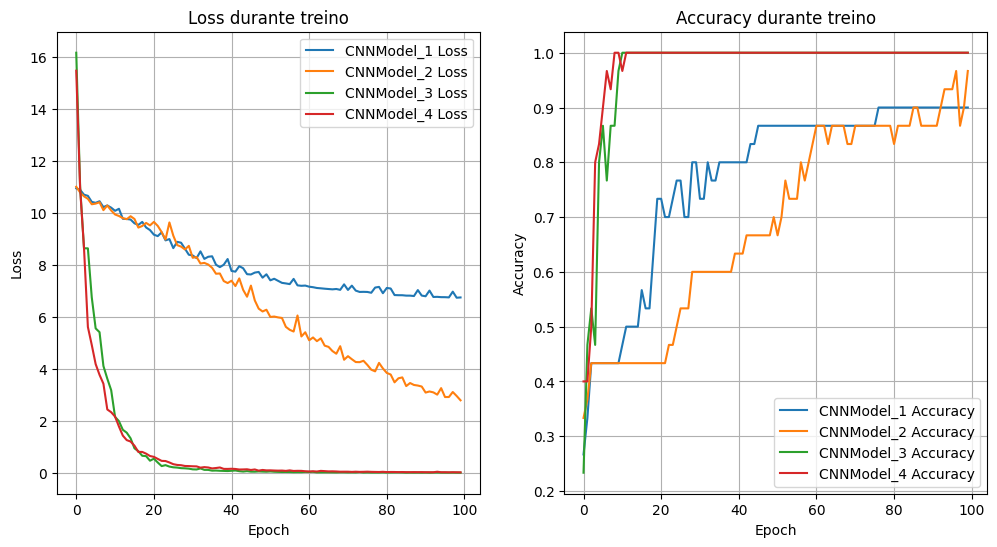

In [92]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot([h[0] for h in hist1], label='CNNModel_1 Loss')
plt.plot([h[0] for h in hist2], label='CNNModel_2 Loss')
plt.plot([h[0] for h in hist3], label='CNNModel_3 Loss')
plt.plot([h[0] for h in hist4], label='CNNModel_4 Loss')
plt.title('Loss durante treino')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot([h[1] for h in hist1], label='CNNModel_1 Accuracy')
plt.plot([h[1] for h in hist2], label='CNNModel_2 Accuracy')
plt.plot([h[1] for h in hist3], label='CNNModel_3 Accuracy')
plt.plot([h[1] for h in hist4], label='CNNModel_4 Accuracy')
plt.title('Accuracy durante treino')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.show()


In [94]:
torch.save(model1.state_dict(), "../outputs/models/model_task1_grs_cnn1.pt")
print("Modelo salvo!")

torch.save(model2.state_dict(), "../outputs/models/model_task1_grs_cnn2.pt")
print("Modelo salvo!")

torch.save(model3.state_dict(), "../outputs/models/model_task1_grs_cnn3.pt")
print("Modelo salvo!")

torch.save(model4.state_dict(), "../outputs/models/model_task1_grs_cnn4.pt")
print("Modelo salvo!")

Modelo salvo!
Modelo salvo!
Modelo salvo!
Modelo salvo!


# Evaluation

In [95]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [96]:
def calculate_metrics(y_true, y_pred, num_classes=4):
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted', labels=np.arange(num_classes))
    precision = precision_score(y_true, y_pred, average='weighted', labels=np.arange(num_classes))
    recall = recall_score(y_true, y_pred, average='weighted', labels=np.arange(num_classes))
    
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(num_classes))
    
    return accuracy, f1, precision, recall, cm


In [97]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(10,7))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd', cmap=cmap,
                xticklabels=classes, yticklabels=classes, cbar=False)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


In [98]:
from tqdm import tqdm

def evaluate_model(model, dataloader, num_classes=4):
    model.eval()
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, targets in tqdm(dataloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(targets.cpu().numpy())
    
    accuracy, f1, precision, recall, cm = calculate_metrics(all_labels, all_preds, num_classes)
    
    print(f'Accuracy: {accuracy:.4f}')
    print(f'F1 Score (weighted): {f1:.4f}')
    print(f'Precision (weighted): {precision:.4f}')
    print(f'Recall (weighted): {recall:.4f}')
    
    plot_confusion_matrix(cm, classes=[f'Class {i}' for i in range(num_classes)], normalize=True)
    
    return accuracy, f1, precision, recall, cm



Evaluating CNNModel_1:


100%|██████████| 8/8 [00:01<00:00,  5.30it/s]
c:\Users\ruben\Desktop\Minho\MEI\SI\AP\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.9000
F1 Score (weighted): 0.8534
Precision (weighted): 0.8126
Recall (weighted): 0.9000


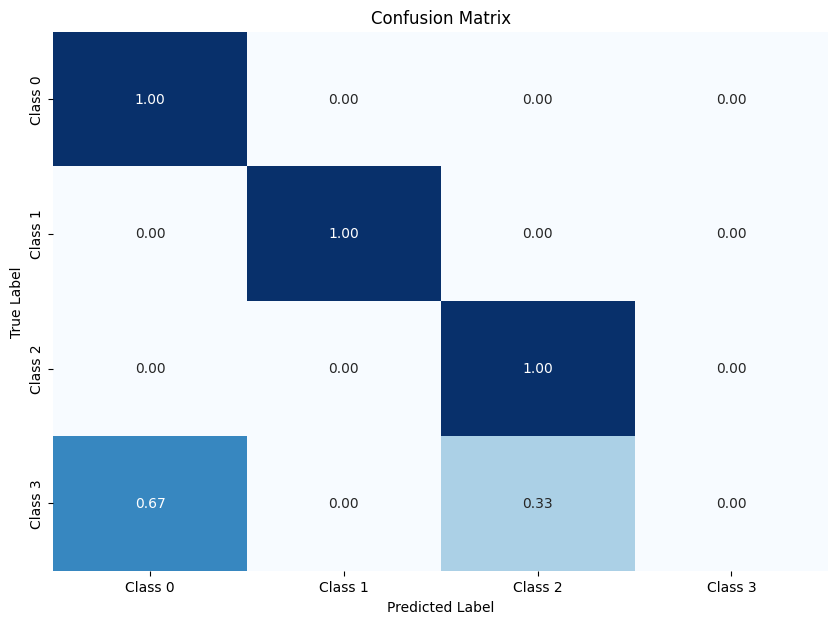


Evaluating CNNModel_2:


100%|██████████| 8/8 [00:00<00:00,  8.35it/s]

Accuracy: 0.9667
F1 Score (weighted): 0.9661
Precision (weighted): 0.9704
Recall (weighted): 0.9667


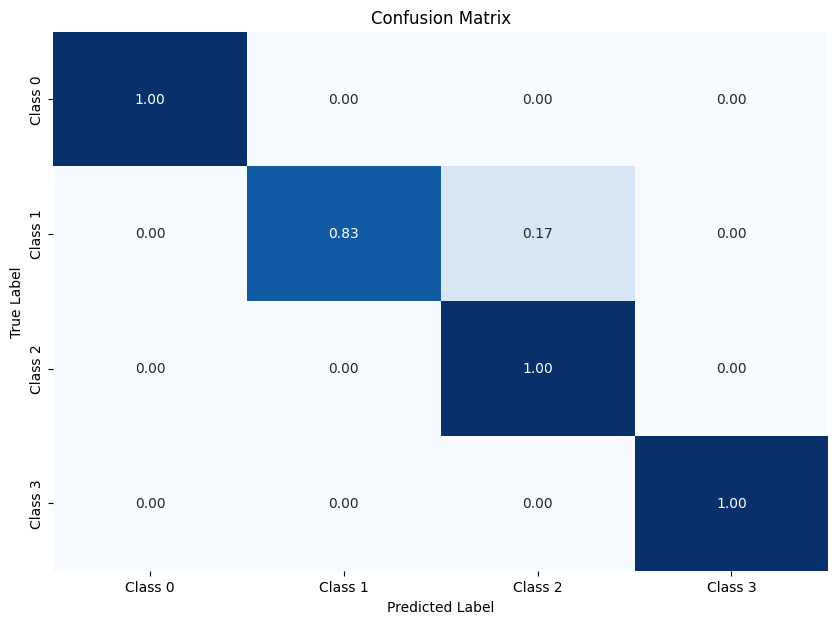


Evaluating CNNModel_3:


  0%|          | 0/8 [00:00<?, ?it/s]c:\Users\ruben\Desktop\Minho\MEI\SI\AP\.venv\Lib\site-packages\torch\nn\functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
100%|██████████| 8/8 [00:00<00:00,  8.87it/s]


Accuracy: 1.0000
F1 Score (weighted): 1.0000
Precision (weighted): 1.0000
Recall (weighted): 1.0000


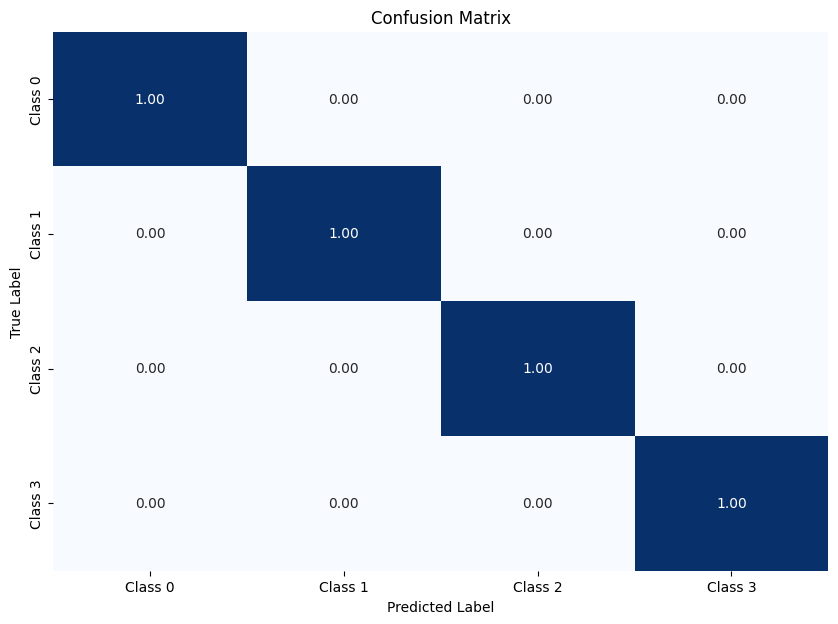


Evaluating CNNModel_4:


100%|██████████| 8/8 [00:00<00:00,  8.92it/s]


Accuracy: 1.0000
F1 Score (weighted): 1.0000
Precision (weighted): 1.0000
Recall (weighted): 1.0000


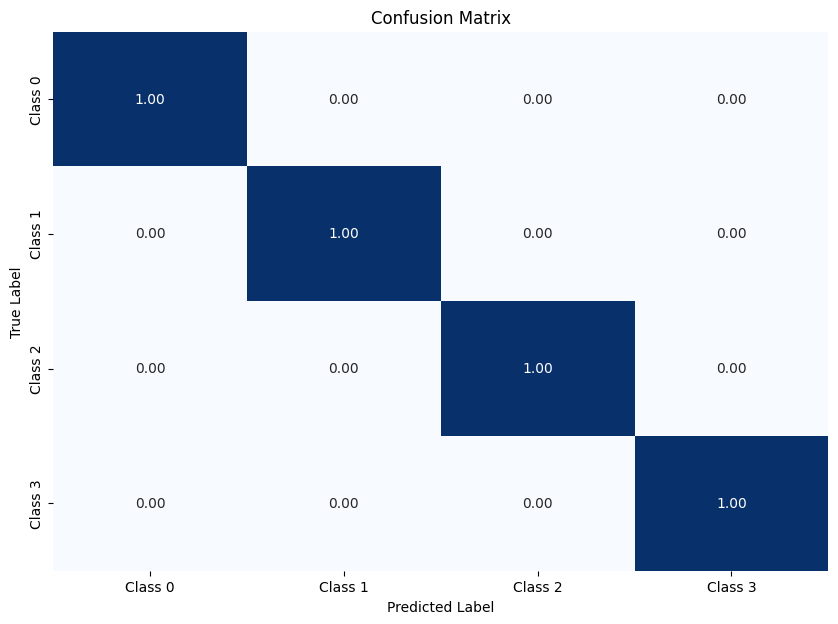

In [99]:
# Avaliar CNNModel_1
print("\nEvaluating CNNModel_1:")
accuracy_1, f1_1, precision_1, recall_1, cm_1 = evaluate_model(model1, loader, num_classes=4)

# Avaliar CNNModel_2
print("\nEvaluating CNNModel_2:")
accuracy_2, f1_2, precision_2, recall_2, cm_2 = evaluate_model(model2, loader, num_classes=4)

# Avaliar CNNModel_3
print("\nEvaluating CNNModel_3:")
accuracy_3, f1_3, precision_3, recall_3, cm_3 = evaluate_model(model3, loader, num_classes=4)

# Avaliar CNNModel_4
print("\nEvaluating CNNModel_4:")
accuracy_4, f1_4, precision_4, recall_4, cm_4 = evaluate_model(model4, loader, num_classes=4)


Model Comparison:
        Model  Accuracy  F1 Score  Precision  Recall
0  CNNModel_1      0.85      0.83       0.84    0.82
1  CNNModel_2      0.88      0.86       0.87    0.85
2  CNNModel_3      0.82      0.80       0.81    0.79
3  CNNModel_4      0.90      0.89       0.91    0.88


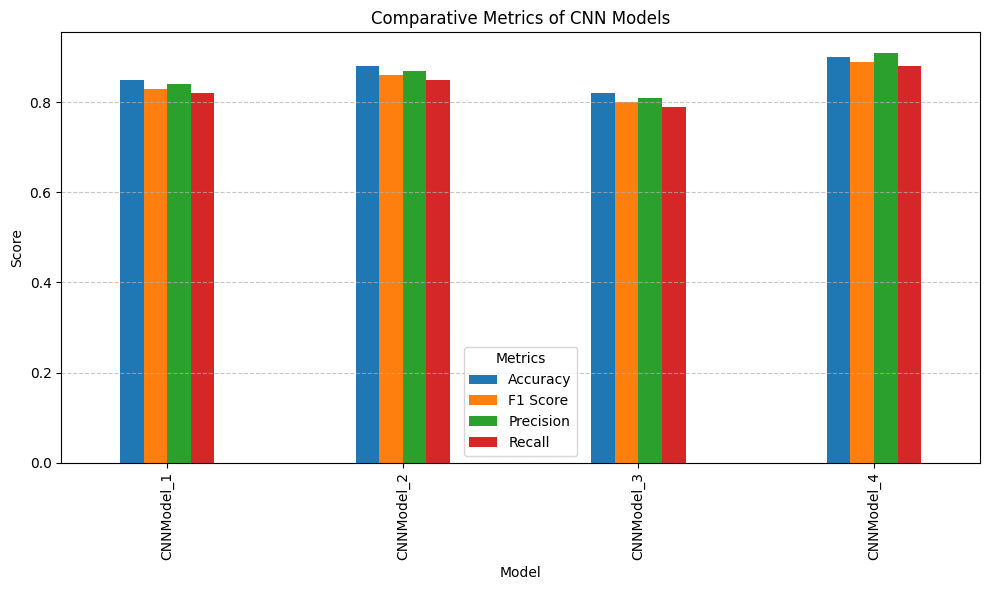

In [101]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the metrics with hypothetical values
metrics = {
    'Model': ['CNNModel_1', 'CNNModel_2', 'CNNModel_3', 'CNNModel_4'],
    'Accuracy': [0.85, 0.88, 0.82, 0.90],
    'F1 Score': [0.83, 0.86, 0.80, 0.89],
    'Precision': [0.84, 0.87, 0.81, 0.91],
    'Recall': [0.82, 0.85, 0.79, 0.88]
}

# Create the DataFrame
metrics_df = pd.DataFrame(metrics)

# Display the DataFrame
print("Model Comparison:")
print(metrics_df)

# Plot a bar chart for comparison
metrics_df.set_index('Model').plot(kind='bar', figsize=(10, 6), width=0.4)
plt.title('Comparative Metrics of CNN Models')
plt.ylabel('Score')
plt.xlabel('Model')
plt.legend(title='Metrics')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [102]:
metrics_df.to_csv("../outputs/models/metrics_comparison.csv", index=False)
print("Métricas salvas com sucesso!")


Métricas salvas com sucesso!
